In [1]:
import numpy as np 
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats

In [ ]:
dict_PatientID_to_MSI_class = {'SC044': 'MSI-H',
                                'P04': 'MSI-H',
                                'P21': 'MSI-H',
                                'P23': 'MSI-H',
                                'CRC2783': 'MSI-I',
                                'SC035': 'MSI-I',
                                'P15': 'MSI-I',
                                'P19': 'MSI-I',
                                'P20': 'MSI-I',
                                'P22': 'MSI-I',
                                'P26': 'MSI-I',
                                'CRC2817': 'MSI-L',
                                'P17': 'MSI-L',
                                'P18': 'MSI-L'}

In [341]:
def calcSampleEnrichment( T_Proportion, N_Proportion, epsilon=(0.1)**6 ):
    return np.log2( (T_Proportion+epsilon)/(N_Proportion+epsilon) )

def getSummarizedInfo( adata, CellTypeProportionByPatient ):

    list_PatientID = list(set(adata.obs['PatientID']))
    dict_PatientID_to_MSI_intensity = { PatientID : np.mean(edf[(edf['Manual_CellType_lvl_2']=='Tumor epithelial')]['MSI_score']) for PatientID, edf in adata.obs.groupby('PatientID', ) } 
    AssociationWithMSIByCellType = list()

    for CellType, edf in CellTypeProportionByPatient[CellTypeProportionByPatient['BiopsySite']=='Tumor'].groupby('CellType', observed=True,):
        dict_PatientID_to_Proportion = { tup.PatientID : tup.Proportion for tup in edf.itertuples() }
        # if len(edf) != len(list_PatientID): 
        #     print(CellType)
        #     continue
        c = 0
        for PatientID in list_PatientID:
            try: dict_PatientID_to_Proportion[PatientID]
            except KeyError: 
                c += 1
                dict_PatientID_to_Proportion[PatientID] = 0
                

        x, y = [ dict_PatientID_to_Proportion[p] for p in list_PatientID ], [ dict_PatientID_to_MSI_intensity[p] for p in list_PatientID ]
        if CellType == 'cDC':
            print(x)
            print(y)
            sns.regplot(x=x, y=y)
        r, pval = scipy.stats.pearsonr( x, y, )
        AssociationWithMSIByCellType.append( [CellType, r, pval, len(list_PatientID)-c] )

    AssociationWithMSIByCellType = pd.DataFrame(AssociationWithMSIByCellType, columns=['CellType', 'R', 'pval', 'n_patients'])

    SampleEnrichmentByCellType = list()
    T_totalCellCount = sum(CellTypeProportionByPatient[CellTypeProportionByPatient['BiopsySite']=='Tumor']['Count'])
    N_totalCellCount = sum(CellTypeProportionByPatient[CellTypeProportionByPatient['BiopsySite']=='Normal']['Count'])
    print(T_totalCellCount, N_totalCellCount)
    dict_BiopsySite_to_TotalCount = { 'Tumor' : T_totalCellCount,'Normal' : N_totalCellCount }

    for CellType, edf in CellTypeProportionByPatient.groupby('CellType'):
        # dict_BiopsySite_to_Proportion = { tup.BiopsySite : tup.Proportion for tup in edf.itertuples() }
        dict_BiopsySite_to_Proportion = { BiopsySite : sum(edf2['Count'])/dict_BiopsySite_to_TotalCount[BiopsySite] for BiopsySite, edf2 in edf.groupby('BiopsySite') }
        if 'Tumor' not in list(dict_BiopsySite_to_Proportion.keys()): dict_BiopsySite_to_Proportion['Tumor'] = 0 
        if 'Normal' not in list(dict_BiopsySite_to_Proportion.keys()): dict_BiopsySite_to_Proportion['Normal'] = 0 

        SampleEnrichmentByCellType.append( [CellType, calcSampleEnrichment(dict_BiopsySite_to_Proportion['Tumor'], dict_BiopsySite_to_Proportion['Normal'])] )
    SampleEnrichmentByCellType = pd.DataFrame(SampleEnrichmentByCellType, columns=['CellType', 'Enrichment'])

    dict_CellType_to_SummarizedInfo = dict()
    for tup in SampleEnrichmentByCellType[SampleEnrichmentByCellType['CellType'].isin( AssociationWithMSIByCellType['CellType'] )].itertuples():
        dict_CellType_to_SummarizedInfo[tup.CellType] = [tup.Enrichment] 
    for tup in AssociationWithMSIByCellType[AssociationWithMSIByCellType['CellType'].isin( SampleEnrichmentByCellType['CellType'] )].itertuples():
        dict_CellType_to_SummarizedInfo[tup.CellType].append( tup.R )
        dict_CellType_to_SummarizedInfo[tup.CellType].append( tup.pval )
        dict_CellType_to_SummarizedInfo[tup.CellType].append( tup.n_patients )

    SummarizedInfo = pd.DataFrame(dict_CellType_to_SummarizedInfo).T
    SummarizedInfo.reset_index(inplace=True)
    SummarizedInfo.columns = ['CellType', 'TissueEnrichment', 'CorrelationWithMSI', 'Pvalue', 'n_patients']
    return SummarizedInfo

## Relationship between cell-type proportion and MSI intensity

In [ ]:
adata_C = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/Chen.MSI.preprocessed.NanoMnT.ManualAnnot.MSI_score_labeled.lvl3.h5ad')
adata_J = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/Joanito.MSI.preprocessed.NanoMnT.ManualAnnot.MSI_score_labeled.lvl3.h5ad')

In [292]:
dict_PatientID_C_to_TumorCellCount = { PatientID : len(edf) for PatientID, edf in adata_C.obs[(adata_C.obs['Manual_CellType_lvl_3']=='Tumor cell')].groupby('PatientID', observed=True) }
dict_PatientID_J_to_TumorCellCount = { PatientID : len(edf) for PatientID, edf in adata_J.obs[(adata_J.obs['Manual_CellType_lvl_3']=='Tumor cell')].groupby('PatientID', observed=True) }

In [331]:
CellTypeProportion_C = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellTypeProportion.tsv', sep='\t')
CellTypeProportion_J = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/4_TME/CellTypeProportion.tsv', sep='\t')
CellTypeProportion_C['MSI_class'] = [ dict_PatientID_to_MSI_class[PID] for PID in CellTypeProportion_C['PatientID'] ]
CellTypeProportion_J['MSI_class'] = [ dict_PatientID_to_MSI_class[PID] for PID in CellTypeProportion_J['PatientID'] ]
CellTypeProportion_C['TumorCellCount'] = [ dict_PatientID_C_to_TumorCellCount[PID] for PID in CellTypeProportion_C['PatientID'] ]
CellTypeProportion_J['TumorCellCount'] = [ dict_PatientID_J_to_TumorCellCount[PID] for PID in CellTypeProportion_J['PatientID'] ]
CellTypeProportion_C['TumorRelativeCount'] = CellTypeProportion_C['Count']/CellTypeProportion_C['TumorCellCount']
CellTypeProportion_J['TumorRelativeCount'] = CellTypeProportion_J['Count']/CellTypeProportion_J['TumorCellCount']

s = sum(CellTypeProportion_C[(CellTypeProportion_C['PatientID']=='P04') & (CellTypeProportion_C['BiopsySite']=='Tumor')]['Count'])
CellTypeProportion_C[(CellTypeProportion_C['PatientID']=='P04') & (CellTypeProportion_C['BiopsySite']=='Tumor')].head(3)

,PatientID,MSI,BiopsySite,CellType,Count,Proportion,MSI_class,TumorCellCount,TumorRelativeCount
23,P04,MSI,Tumor,CD4+ T,2123,0.362163,MSI-H,1190,1.784034
24,P04,MSI,Tumor,CD8+ T,1790,0.305357,MSI-H,1190,1.504202
25,P04,MSI,Tumor,Endothelial,210,0.035824,MSI-H,1190,0.176471


In [304]:
CellTypeProportion_J[(CellTypeProportion_J['BiopsySite']=='Tumor') & (CellTypeProportion_J['CellType']=='CD4+ T')]

,PatientID,MSI,BiopsySite,CellType,Count,Proportion,MSI_class,TumorCellCount,TumorRelativeCount
24,CRC2783,MSI-H,Tumor,CD4+ T,1191,0.130506,MSI-I,771,1.544747
68,CRC2817,MSI-H,Tumor,CD4+ T,2845,0.277859,MSI-L,1327,2.143934
112,SC035,MSI-H,Tumor,CD4+ T,751,0.309308,MSI-I,1019,0.736997
153,SC044,MSI-H,Tumor,CD4+ T,522,0.237165,MSI-H,373,1.399464


[0.0021886627270737, 0.0011350737797956, 0.0027122887544335, 0.0056662758890191, 0.0127942681678608, 0.0025983667409057, 0.0080625458099193, 0.002805049088359, 0.0011488383967321, 0.001327517542196]
[4.818777140883732, 1.2597684018086597, 3.2527255511957964, 3.320250707611496, 6.600170215466162, 3.424761624148185, 5.228585165446596, 2.163172775984861, 3.2800240611752773, 4.473529075630034]
45731 52566


/tmp/ipykernel_180379/2331770311.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dict_PatientID_to_MSI_intensity = { PatientID : np.mean(edf[(edf['Manual_CellType_lvl_2']=='Tumor epithelial')]['MSI_score']) for PatientID, edf in adata.obs.groupby('PatientID', ) }


,CellType,TissueEnrichment,CorrelationWithMSI,Pvalue,n_patients,abs_cor
21,cDC,0.039310,0.723004,0.018144,10.0,0.723004
15,NK,1.427605,0.721277,0.018558,10.0,0.721277
0,CD4+ T,0.382784,0.647493,0.042964,10.0,0.647493
17,Pericyte,1.957717,0.606727,0.062903,10.0,0.606727
20,Tumor cell,8.293154,-0.562356,0.090616,10.0,0.562356
14,Monocyte,4.797219,-0.531214,0.114091,10.0,0.531214
11,Macrophage,0.775429,-0.529384,0.115578,10.0,0.529384
1,CD8+ T,0.566590,0.528885,0.115986,10.0,0.528885
4,Fibroblast,-3.342925,0.499282,0.141777,10.0,0.499282
13,Memory B,-0.953233,0.306188,0.389553,9.0,0.306188


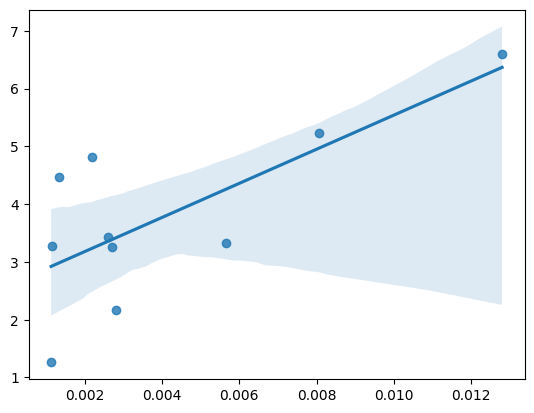

In [346]:
SummarizedInfo_C1 = getSummarizedInfo(adata_C, CellTypeProportion_C).sort_values('Pvalue')
SummarizedInfo_C1['abs_cor'] = [ abs(c) for c in SummarizedInfo_C1['CorrelationWithMSI'] ]
SummarizedInfo_C1.sort_values('abs_cor', ascending=False,).head(10)

/tmp/ipykernel_180379/2014509623.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dict_PatientID_to_MSI_intensity = { PatientID : np.mean(edf[(edf['Manual_CellType_lvl_2']=='Tumor epithelial')]['MSI_score']) for PatientID, edf in adata_C.obs.groupby('PatientID', ) }


Monocyte -0.152 0.676
Macrophage -0.6 0.067


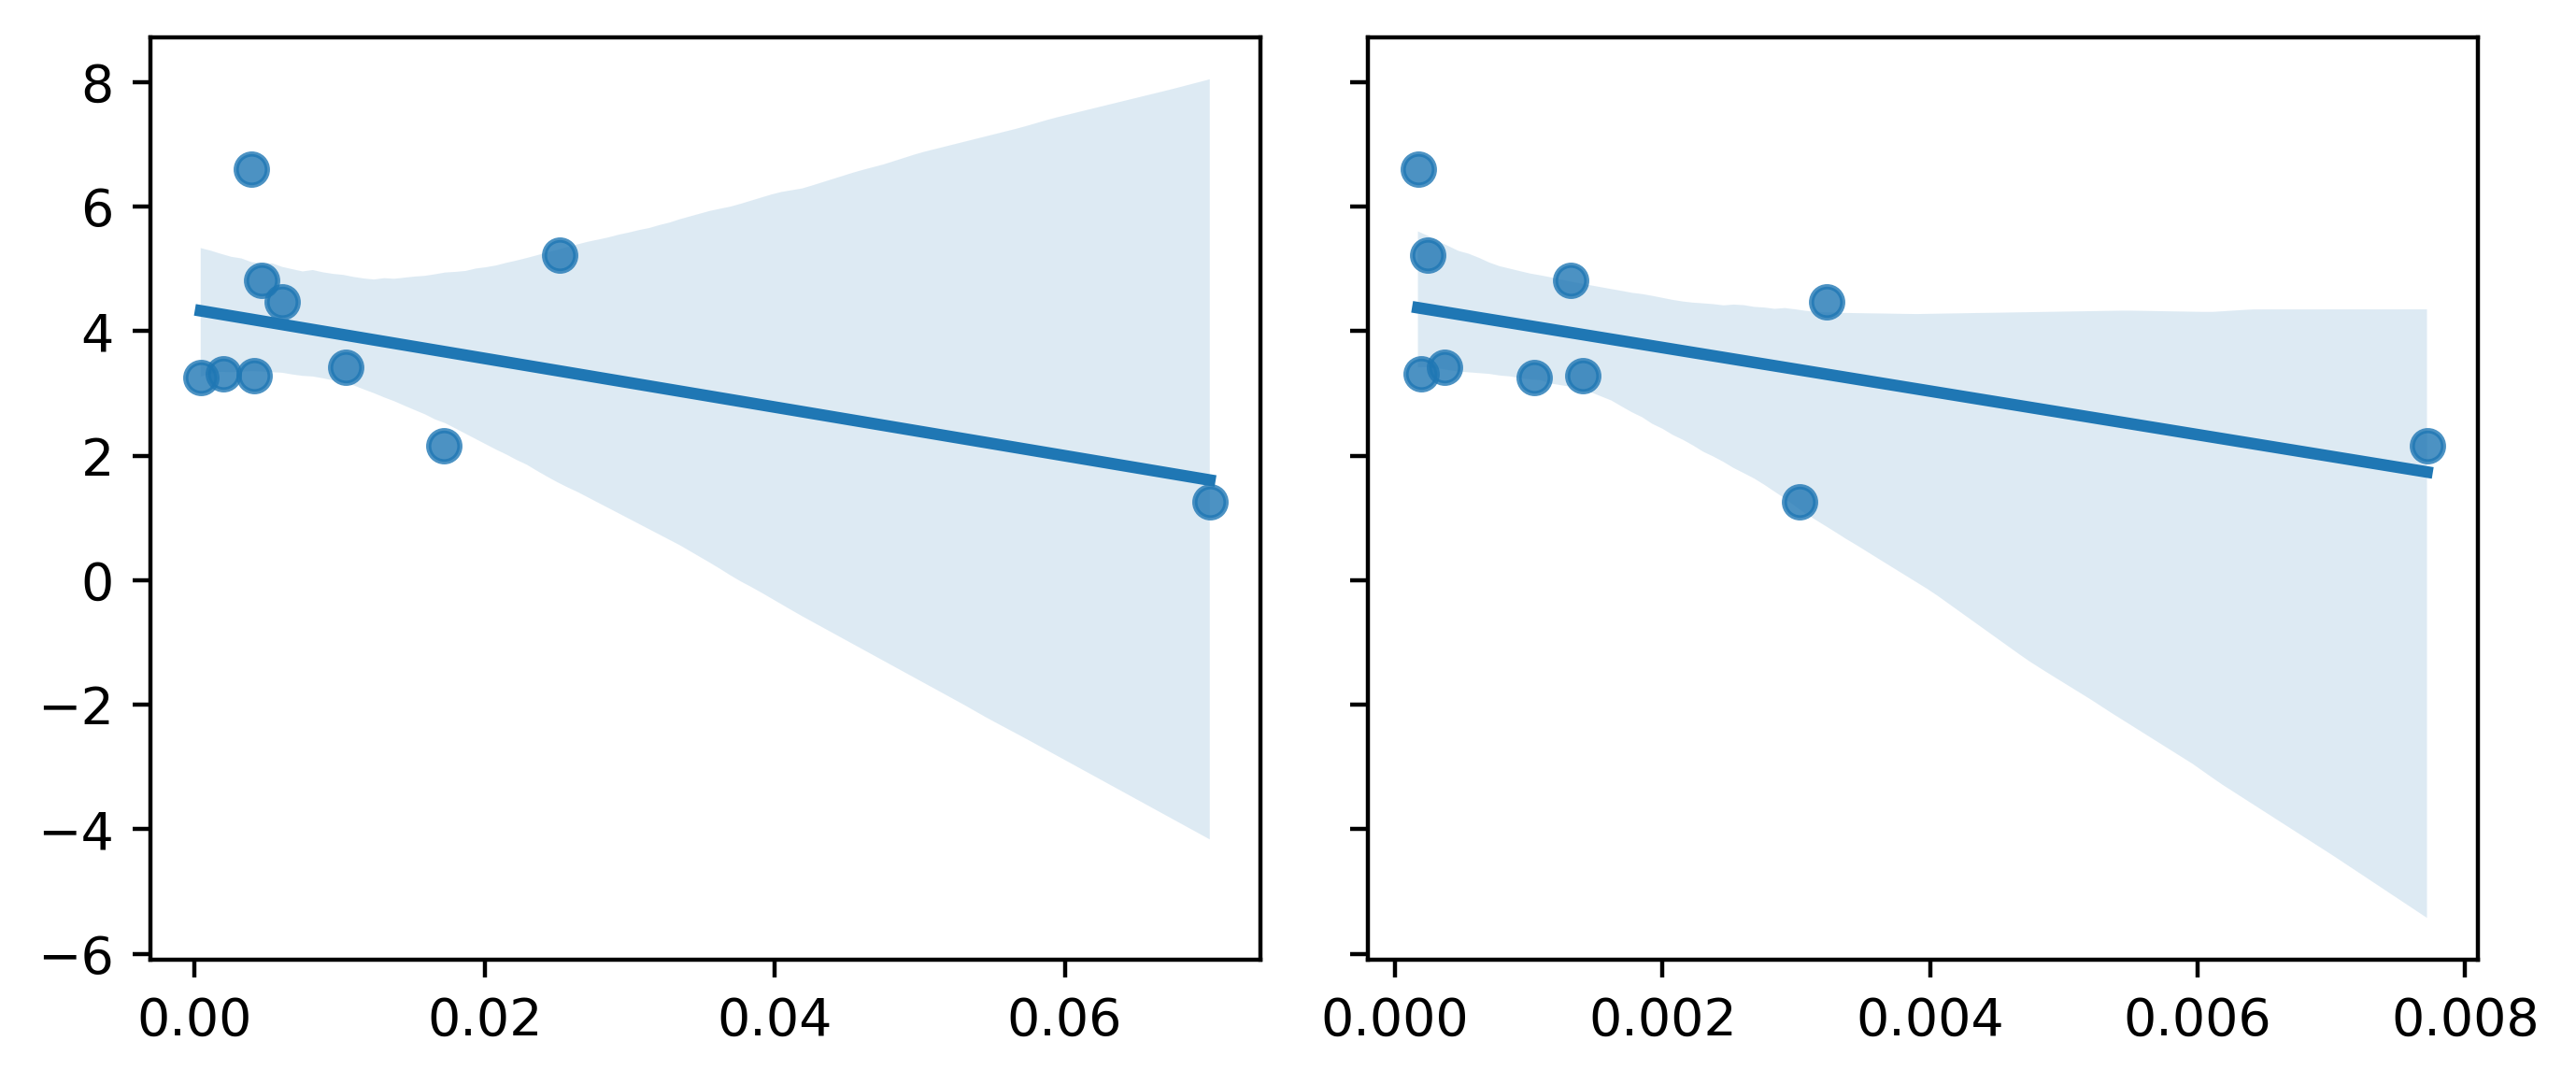

In [468]:
list_PatientID = list(set(CellTypeProportion_C['PatientID']))
dict_PatientID_to_MSI_intensity = { PatientID : np.mean(edf[(edf['Manual_CellType_lvl_2']=='Tumor epithelial')]['MSI_score']) for PatientID, edf in adata_C.obs.groupby('PatientID', ) } 

# CellTypes_of_interest = ['CD8+ T', 'CD4+ T', 'NK']
# CellTypes_of_interest = ['Naive B', 'GC B', 'Memory B', 'IGHG+ Plasma', 'IGHA+ Plasma']
CellTypes_of_interest = ['Monocyte', 'Macrophage', ]
# CellTypes_of_interest = ['cDC', 'pDC',]
# CellTypes_of_interest = ['Fibroblast', 'SOX6+ Fibroblast', 'Endothelial', 'SMC', 'Pericyte']
# CellTypes_of_interest = ['Enterocytes', 'Goblet', 'Intestinal stem']


fig, axes = plt.subplots( 1, len(CellTypes_of_interest), figsize=(3.5*len(CellTypes_of_interest), 3), 
                         sharex=False, sharey=True,
                         dpi=400,
                         )

dict_CellType_to_CorrelationInfo = dict()

for CellType, edf in CellTypeProportion_C[(CellTypeProportion_C['BiopsySite']=='Tumor') & (CellTypeProportion_C['BiopsySite']=='Tumor')].groupby('CellType', observed=True,):
    dict_PatientID_to_Proportion = { tup.PatientID : tup.Proportion for tup in edf.itertuples() }
    # if len(edf) != len(list_PatientID): 
    #     print(CellType)
    #     continue
    c = 0
    for PatientID in list_PatientID:
        try: dict_PatientID_to_Proportion[PatientID]
        except KeyError: 
            c += 1
            dict_PatientID_to_Proportion[PatientID] = 0
            

    x, y = [ dict_PatientID_to_Proportion[p] for p in list_PatientID ], [ dict_PatientID_to_MSI_intensity[p] for p in list_PatientID ]
    dict_CellType_to_CorrelationInfo[CellType] = [ x, y ]
    # r, pval = scipy.stats.pearsonr( x, y, )
    

    # if CellType in CellTypes_of_interest:
    #     print(CellType)
    #     plt.figure(figsize=(4, 3), dpi=300)
        
    #     ax = sns.regplot(x=x, y=y,)
    #     ax.set_xticklabels([]);
    #     ax.set_yticklabels([]);
    #     print(f'{CellType}\t{round(r, 3)}\t{round(pval, 3)}')

for idx, CellType in enumerate(CellTypes_of_interest):
    r, pval = scipy.stats.spearmanr( dict_CellType_to_CorrelationInfo[CellType][0], dict_CellType_to_CorrelationInfo[CellType][1] )
    print(CellType, round(r, 3), round(pval, 3))
    f = sns.regplot(x=dict_CellType_to_CorrelationInfo[CellType][0], 
                y=dict_CellType_to_CorrelationInfo[CellType][1], 
                # robust=True,
                ax=axes[idx])
    # f.set_xticklabels([]);
    # f.set_yticklabels([]);
    # if idx != 0: f.set_yticks([]);
fig.tight_layout()

In [437]:
CellTypeProportion_J[(CellTypeProportion_J['PatientID']=='CRC2817') & (CellTypeProportion_J['BiopsySite']=='Tumor')]

,PatientID,MSI,BiopsySite,CellType,Count,Proportion,MSI_class,TumorCellCount,TumorRelativeCount
70,CRC2817,MSI-H,Tumor,CD4+ T,2845,0.251948,MSI-L,1327,2.143934
71,CRC2817,MSI-H,Tumor,CD8+ T,1635,0.144793,MSI-L,1327,1.232102
72,CRC2817,MSI-H,Tumor,Endothelial,202,0.017889,MSI-L,1327,0.152223
73,CRC2817,MSI-H,Tumor,Fibroblast,344,0.030464,MSI-L,1327,0.259231
74,CRC2817,MSI-H,Tumor,GC B,34,0.003011,MSI-L,1327,0.025622
75,CRC2817,MSI-H,Tumor,Glial,6,0.000531,MSI-L,1327,0.004521
76,CRC2817,MSI-H,Tumor,Goblet,18,0.001594,MSI-L,1327,0.013564
77,CRC2817,MSI-H,Tumor,IGHA+ Plasma,431,0.038169,MSI-L,1327,0.324793
78,CRC2817,MSI-H,Tumor,IGHG+ Plasma,54,0.004782,MSI-L,1327,0.040693
79,CRC2817,MSI-H,Tumor,ILC,64,0.005668,MSI-L,1327,0.048229


In [435]:
751/3447

0.2178706121264868

In [434]:
sum(CellTypeProportion_J[(CellTypeProportion_J['PatientID']=='SC035') & (CellTypeProportion_J['BiopsySite']=='Tumor')]['Count'])

3447

/tmp/ipykernel_180379/4290396430.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dict_PatientID_to_MSI_intensity = { PatientID : np.mean(edf[(edf['Manual_CellType_lvl_2']=='Tumor epithelial')]['MSI_score']) for PatientID, edf in adata_J.obs.groupby('PatientID', ) }


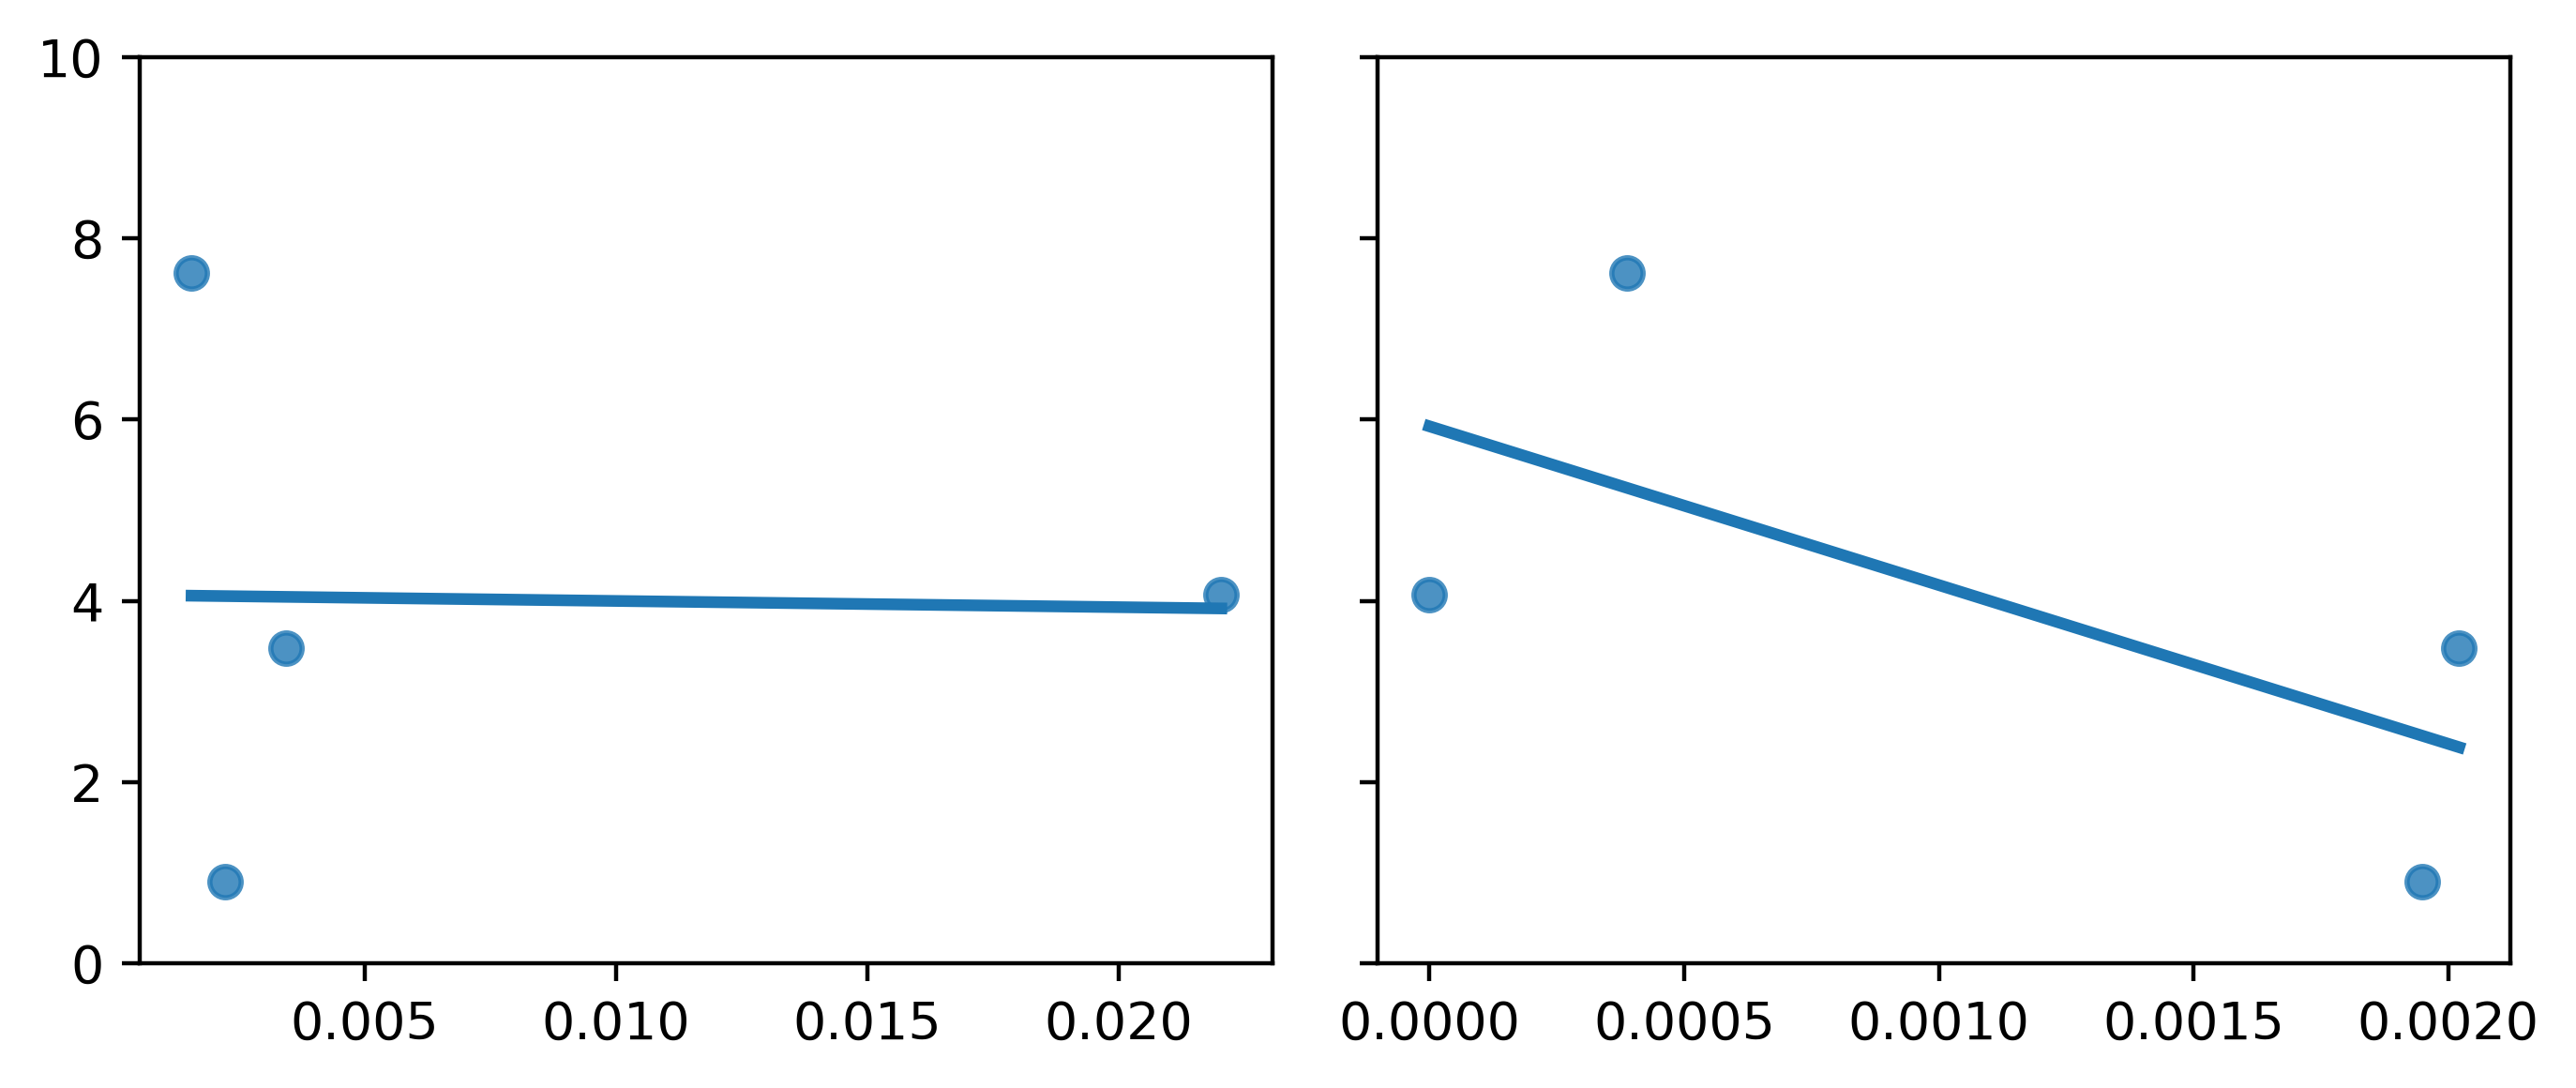

In [450]:
list_PatientID = list(set(CellTypeProportion_J['PatientID']))
dict_PatientID_to_MSI_intensity = { PatientID : np.mean(edf[(edf['Manual_CellType_lvl_2']=='Tumor epithelial')]['MSI_score']) for PatientID, edf in adata_J.obs.groupby('PatientID', ) } 

# CellTypes_of_interest = ['CD8+ T', 'CD4+ T', 'NK']
# CellTypes_of_interest = ['Naive B', 'GC B', 'Memory B', 'IGHG+ Plasma', 'IGHA+ Plasma']
# CellTypes_of_interest = ['Monocyte', 'Macrophage', ]
CellTypes_of_interest = ['cDC', 'pDC',]
# CellTypes_of_interest = ['Fibroblast', 'SOX6+ Fibroblast', 'Endothelial', 'SMC', 'Pericyte']
# CellTypes_of_interest = ['Enterocytes', 'Goblet', 'Intestinal stem']


fig, axes = plt.subplots( 1, len(CellTypes_of_interest), figsize=(3.5*len(CellTypes_of_interest), 3), 
                         sharex=False, sharey=True,
                         dpi=400,
                         )

dict_CellType_to_CorrelationInfo = dict()

for CellType, edf in CellTypeProportion_J[(CellTypeProportion_J['BiopsySite']=='Tumor')].groupby('CellType', observed=True,):
    dict_PatientID_to_Proportion = { tup.PatientID : tup.Proportion for tup in edf.itertuples() }
    # if len(edf) != len(list_PatientID): 
    #     print(CellType)
    #     continue
    c = 0
    for PatientID in list_PatientID:
        try: dict_PatientID_to_Proportion[PatientID]
        except KeyError: 
            c += 1
            dict_PatientID_to_Proportion[PatientID] = 0
            

    x, y = [ dict_PatientID_to_Proportion[p] for p in list_PatientID ], [ dict_PatientID_to_MSI_intensity[p] for p in list_PatientID ]
    dict_CellType_to_CorrelationInfo[CellType] = [ x, y ]
    # r, pval = scipy.stats.pearsonr( x, y, )
    

    # if CellType in CellTypes_of_interest:
    #     print(CellType)
    #     plt.figure(figsize=(4, 3), dpi=300)
        
    #     ax = sns.regplot(x=x, y=y,)
    #     ax.set_xticklabels([]);
    #     ax.set_yticklabels([]);
    #     print(f'{CellType}\t{round(r, 3)}\t{round(pval, 3)}')

for idx, CellType in enumerate(CellTypes_of_interest):
    f = sns.regplot(x=dict_CellType_to_CorrelationInfo[CellType][0], 
                y=dict_CellType_to_CorrelationInfo[CellType][1],
                ci=None,
                ax=axes[idx])
    f.set_ylim([0, 10])
    # f.set_xticklabels([]);
    # f.set_yticklabels([]);
    # if idx != 0: f.set_yticks([]);
fig.tight_layout()

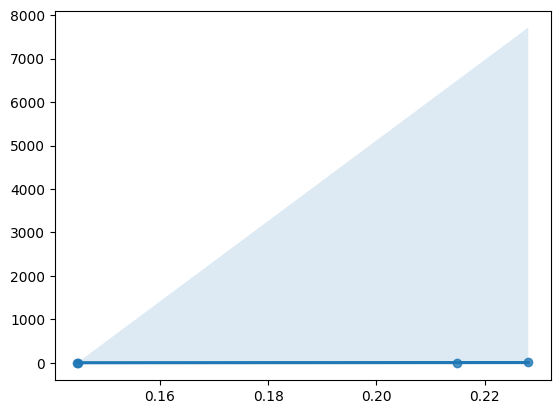

In [421]:
f = sns.regplot(x=dict_CellType_to_CorrelationInfo['CD8+ T'][0], 
            y=dict_CellType_to_CorrelationInfo['CD8+ T'][1], 
            # ax=axes[idx]
            )

[0.0021886627270737, 0.0011350737797956, 0.0027122887544335, 0.0056662758890191, 0.0127942681678608, 0.0025983667409057, 0.0080625458099193, 0.002805049088359, 0.0011488383967321, 0.001327517542196]
[4.818777140883732, 1.2597684018086597, 3.2527255511957964, 3.320250707611496, 6.600170215466162, 3.424761624148185, 5.228585165446596, 2.163172775984861, 3.2800240611752773, 4.473529075630034]
45731 52566


/tmp/ipykernel_180379/2331770311.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dict_PatientID_to_MSI_intensity = { PatientID : np.mean(edf[(edf['Manual_CellType_lvl_2']=='Tumor epithelial')]['MSI_score']) for PatientID, edf in adata.obs.groupby('PatientID', ) }


,CellType,TissueEnrichment,CorrelationWithMSI,Pvalue,n_patients
21,cDC,0.039310,0.723004,0.018144,10.0
15,NK,1.427605,0.721277,0.018558,10.0
0,CD4+ T,0.382784,0.647493,0.042964,10.0
17,Pericyte,1.957717,0.606727,0.062903,10.0
20,Tumor cell,8.293154,-0.562356,0.090616,10.0
14,Monocyte,4.797219,-0.531214,0.114091,10.0
11,Macrophage,0.775429,-0.529384,0.115578,10.0
1,CD8+ T,0.566590,0.528885,0.115986,10.0
4,Fibroblast,-3.342925,0.499282,0.141777,10.0
13,Memory B,-0.953233,0.306188,0.389553,9.0


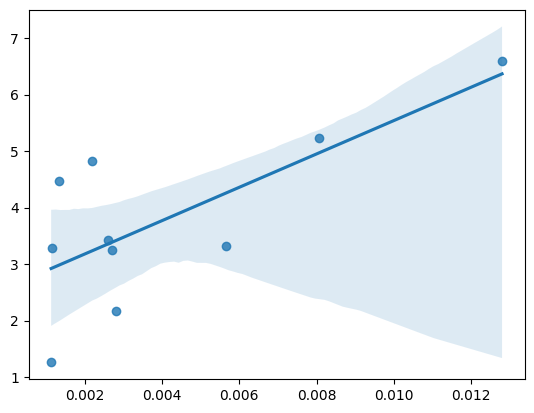

In [451]:
getSummarizedInfo(adata_C[adata_C.obs['MSI']=='MSI'], CellTypeProportion_C).sort_values('Pvalue')

In [299]:
SummarizedInfo_C = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellType_MSI_intensity.tsv', sep='\t')
SummarizedInfo_J = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/4_TME/CellType_MSI_intensity.tsv', sep='\t')

SummarizedInfo_C['log10_pvalue'] = [ -np.log10(pval) for pval in SummarizedInfo_C['Pvalue'] ]
SummarizedInfo_J['log10_pvalue'] = [ -np.log10(pval) for pval in SummarizedInfo_J['Pvalue'] ]
SummarizedInfo_J

,CellType,TissueEnrichment,CorrelationWithMSI,Pvalue,n_patients,log10_pvalue
0,CD4+ T,0.267016,-0.101970,0.898030,4,0.046709
1,CD8+ T,1.139957,0.630555,0.369445,4,0.432450
2,Endothelial,0.122874,0.016566,0.983434,4,0.007255
3,Fibroblast,-0.057606,-0.039033,0.960967,4,0.017292
4,GC B,-0.767763,0.569319,0.430681,4,0.365844
5,Glial,-6.506282,-0.750993,0.249007,1,0.603789
6,Goblet,-3.482482,-0.750993,0.249007,1,0.603789
7,IGHA+ Plasma,-3.842184,-0.771498,0.228502,4,0.641111
8,IGHG+ Plasma,4.679318,0.343309,0.656691,4,0.182639
9,ILC,-1.016364,-0.859591,0.140409,4,0.852606


In [137]:
chen_patient_order_by_MSI_intensity     = ['P18', 'P17', 'P15', 'P26', 'P20', 'P19', 'P22', 'P23', 'P21', 'P04']
joanito_patient_order_by_MSI_intensity  = ['CRC2817', 'CRC2783', 'SC035', 'SC044']

In [280]:
intersecting_CellTypes = set(SummarizedInfo_J['CellType']).intersection(set(SummarizedInfo_C['CellType']))

In [281]:
set(SummarizedInfo_J['CellType']).difference(set(SummarizedInfo_C['CellType']))

{'ILC', 'Transit-amplifying cell'}

In [282]:
set(SummarizedInfo_C['CellType']).difference(set(SummarizedInfo_J['CellType']))

{'Enterocytes', 'Intestinal stem'}

In [283]:
palette_e=[
    'black', 'dimgrey', 'darkgrey',     # black x 3 
    'lightcoral', 'tomato' ,'darkred',  # red x 3
    'chocolate', 'darkorange', 'navajowhite',   # orange x 3
    'darkgoldenrod', 'gold', 'khaki',   # yellow x 3
    'yellowgreen', 'darkolivegreen', 'lawngreen', 'forestgreen', # green x 4
    'aquamarine', 'mediumturquoise', 'darkslategrey', 'cyan', 'deepskyblue', 'dodgerblue', # blue x 6
    'mediumslateblue', 'indigo', 'magenta', 'crimson', # other x 4 
]

palette_e=[
    'lightcoral', 'tomato' ,'darkred',          # red x 3
    'chocolate', 'darkorange', 'navajowhite',   # orange x 3
    'darkgoldenrod', 'gold',                    # yellow x 2
    'black', 'dimgrey',                         # black x 2
    'yellowgreen', 'darkolivegreen', 'lawngreen', 'forestgreen', # green x 4
    'darkslategrey', 'cyan', 'deepskyblue', 'dodgerblue', # blue x 5
    'mediumslateblue', 'indigo', 'magenta',             # other x 2 
]
palette_e = list(pd.DataFrame(palette_e).sample(frac=1, random_state=42)[0])

In [59]:
sns.color_palette('husl', 10)

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.8616090647292522, 0.536495730113334, 0.19548899031476086),
 (0.6804189127793346, 0.6151497514677574, 0.19405452111445337),
 (0.46810256823426105, 0.6699492535792404, 0.1928958739904499),
 (0.20125317221201128, 0.6907920815379026, 0.47966761189275336),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.2197995660828324, 0.6625157876850336, 0.7732093159317209),
 (0.433280341176423, 0.6065273407962815, 0.9585467098271748),
 (0.8004936186423958, 0.47703363533737203, 0.9579547196007522),
 (0.9622723935096688, 0.3976451968965351, 0.8008274363432775)]

/tmp/ipykernel_180379/1090922219.py:2: UserWarning: The palette list has more values (21) than needed (19), which may not be intended.
  ax1 = sns.scatterplot(data=SummarizedInfo_J[(SummarizedInfo_J['CellType'].isin(intersecting_CellTypes)) &
/tmp/ipykernel_180379/1090922219.py:10: UserWarning: The palette list has more values (21) than needed (17), which may not be intended.
  ax2 = sns.scatterplot(data=SummarizedInfo_C[(SummarizedInfo_C['CellType'].isin(intersecting_CellTypes)) &


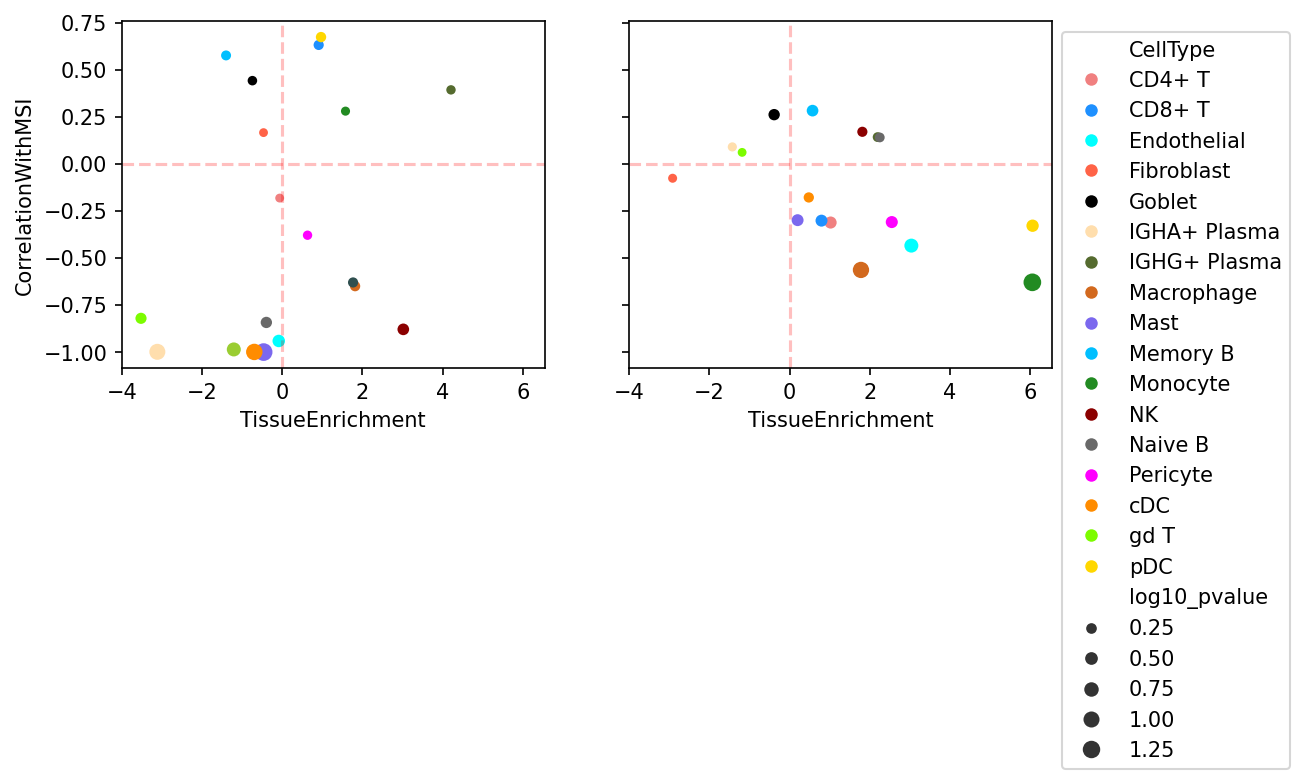

In [284]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True, dpi=150)
ax1 = sns.scatterplot(data=SummarizedInfo_J[(SummarizedInfo_J['CellType'].isin(intersecting_CellTypes)) & 
                                            (SummarizedInfo_J['n_patients']>=2)], x='TissueEnrichment', y='CorrelationWithMSI', size='log10_pvalue', 
                      hue='CellType',
                      palette=palette_e,
                      ax=axes[0], legend=None, **{'linewidths':0})
ax1.axhline(0, color='red', ls='--', alpha=0.25,)
ax1.axvline(0, color='red', ls='--', alpha=0.25,)

ax2 = sns.scatterplot(data=SummarizedInfo_C[(SummarizedInfo_C['CellType'].isin(intersecting_CellTypes)) & 
                                            (SummarizedInfo_C['n_patients']>=5)], x='TissueEnrichment', y='CorrelationWithMSI', 
                      size='log10_pvalue',
                      hue='CellType',
                    #   palette=sns.color_palette('colorblind')+sns.color_palette('husl', 10)+['black'],
                      palette=palette_e,
                      ax=axes[1], legend=True, **{'linewidths':0})
ax2.axhline(0, color='red', ls='--', alpha=0.25,)
ax2.axvline(0, color='red', ls='--', alpha=0.25,)
sns.move_legend(ax2, "upper left", bbox_to_anchor=(1, 1))

In [114]:
SummarizedInfo_J

,CellType,TissueEnrichment,CorrelationWithMSI,Pvalue,n_patients,log10_pvalue,log10_TissueEnrichment
0,CD4+ T,0.267016,-0.101107,0.898893,4,0.046292,0.573463
1,CD8+ T,1.139957,0.630913,0.369087,4,0.432872,-0.056888
2,Endothelial,0.122874,0.018420,0.981580,4,0.008074,0.910540
3,Fibroblast,-0.057606,-0.038763,0.961237,4,0.017170,NaN
4,GC B,-0.767763,0.570891,0.429109,4,0.367432,NaN
5,Glial,-6.506282,-0.750993,0.249007,1,0.603789,NaN
6,Goblet,-3.482482,-0.750993,0.249007,1,0.603789,NaN
7,IGHA+ Plasma,-3.842184,-0.771364,0.228636,4,0.640856,NaN
8,IGHG+ Plasma,4.679318,0.343974,0.656026,4,0.183079,-0.670183
9,ILC,-1.016364,-0.859429,0.140571,4,0.852105,NaN


In [285]:
dict_CellType_to_Info = dict()
for tup in SummarizedInfo_C.itertuples():
    dict_CellType_to_Info[tup.CellType] = [ tup.TissueEnrichment, tup.CorrelationWithMSI, tup.Pvalue, 0, 0, 0 ]
for tup in SummarizedInfo_J.itertuples():
    try:
        dict_CellType_to_Info[tup.CellType][3] = tup.TissueEnrichment
        dict_CellType_to_Info[tup.CellType][4] = tup.CorrelationWithMSI
        dict_CellType_to_Info[tup.CellType][5] = tup.Pvalue
    except KeyError:
        dict_CellType_to_Info[tup.CellType] = [ 0,0,0, tup.TissueEnrichment, tup.CorrelationWithMSI, tup.Pvalue ]

SummarizedInfo_concat = pd.DataFrame(dict_CellType_to_Info,).T
SummarizedInfo_concat.reset_index(inplace=True)
SummarizedInfo_concat.columns = ['CellType', 
                                 'TissueEnrichment_C', 'CorrelationWithMSI_C', 'pvalue_C', 
                                 'TissueEnrichment_J', 'CorrelationWithMSI_J', 'pvalue_J']

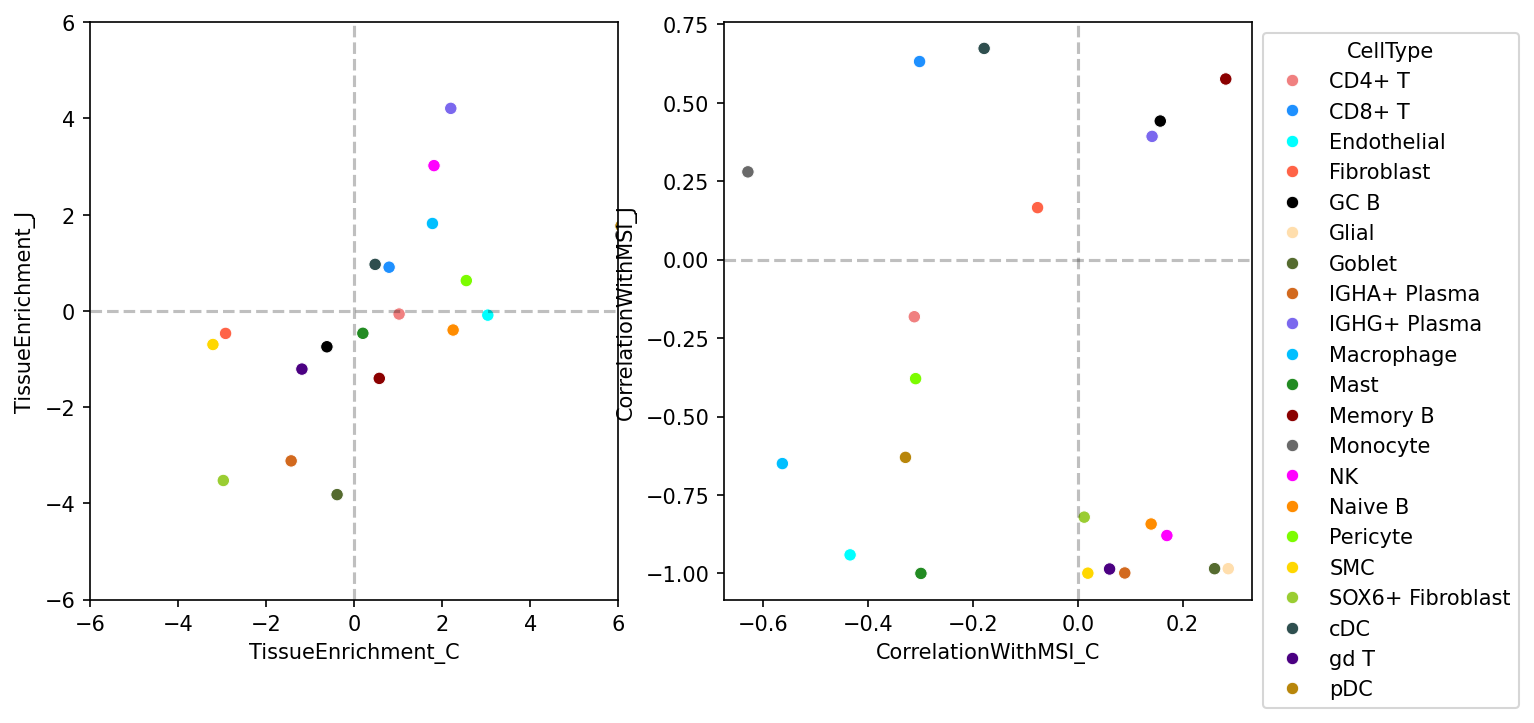

In [287]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=150)
ax1 = sns.scatterplot(data=SummarizedInfo_concat[SummarizedInfo_concat['CellType'].isin(intersecting_CellTypes)], 
                     x='TissueEnrichment_C', y='TissueEnrichment_J', hue='CellType',
                     palette=palette_e,
                     legend=None,
                     ax=axes[0])
axes[0].axhline(0, color='black', ls='--', alpha=0.25,)
axes[0].axvline(0, color='black', ls='--', alpha=0.25,)
ax1.set_xlim([-6, 6]);
ax1.set_ylim([-6, 6]);

# sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 1))
ax2 = sns.scatterplot(data=SummarizedInfo_concat[SummarizedInfo_concat['CellType'].isin(intersecting_CellTypes)], 
                     x='CorrelationWithMSI_C', y='CorrelationWithMSI_J', hue='CellType',
                     palette=palette_e,
                     ax=axes[1])
# ax2.set_xlim([-1, 1]);
# ax2.set_ylim([-1, 1]);
axes[1].axhline(0, color='black', ls='--', alpha=0.25,)
axes[1].axvline(0, color='black', ls='--', alpha=0.25,)
# ax2 = sns.lineplot(x=[i*0.1 for i in range(-10, 10)], y=[i*0.1 for i in range(-10, 10)], ax=axes[1], color='gray', alpha=.5,)
sns.move_legend(ax2, "upper left", bbox_to_anchor=(1, 1))

In [278]:
SummarizedInfo_concat

,CellType,TissueEnrichment_C,CorrelationWithMSI_C,pvalue_C,TissueEnrichment_J,CorrelationWithMSI_J,pvalue_J
0,CD4+ T,0.893267,0.296451,0.405562,0.267016,-0.101970,0.898030
1,CD8+ T,1.077073,0.072514,0.842208,1.139957,0.630555,0.369445
2,Endothelial,2.371028,-0.296520,0.405447,0.122874,0.016566,0.983434
3,Enterocytes,-0.932674,0.134939,0.710136,0.000000,0.000000,0.000000
4,Fibroblast,-2.832526,0.115799,0.750060,-0.057606,-0.039033,0.960967
5,GC B,-1.847885,0.107531,0.767476,-0.767763,0.569319,0.430681
6,Glial,-2.722160,0.274403,0.442935,-6.506282,-0.750993,0.249007
7,Goblet,-0.396183,0.123459,0.734012,-3.482482,-0.750993,0.249007
8,IGHA+ Plasma,-1.598647,0.027789,0.939259,-3.842184,-0.771498,0.228502
9,IGHG+ Plasma,2.679269,-0.026901,0.941198,4.679318,0.343309,0.656691


0.6955709996855794 0.000463623834241894
0.13112100801795246 0.5710308409308056


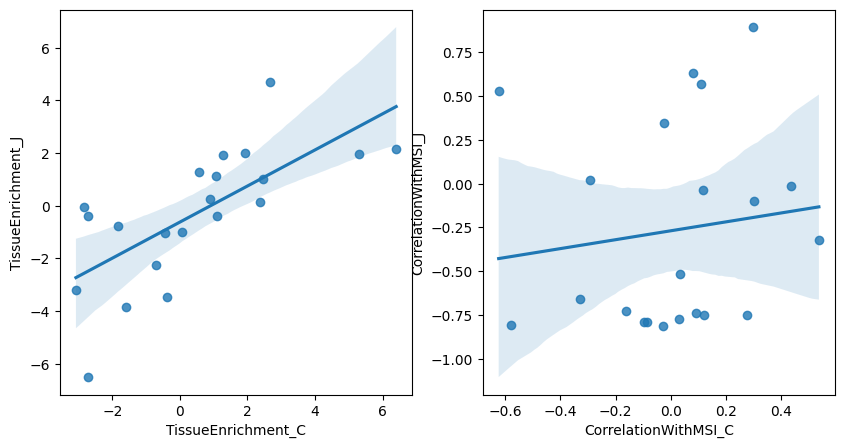

In [119]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = sns.regplot(data=SummarizedInfo_concat[SummarizedInfo_concat['CellType'].isin(intersecting_CellTypes)], 
                     x='TissueEnrichment_C', y='TissueEnrichment_J', ax=axes[0])
ax = sns.regplot(data=SummarizedInfo_concat[SummarizedInfo_concat['CellType'].isin(intersecting_CellTypes)], 
                     x='CorrelationWithMSI_C', y='CorrelationWithMSI_J', ax=axes[1])
r, pval = scipy.stats.pearsonr( SummarizedInfo_concat[SummarizedInfo_concat['CellType'].isin(intersecting_CellTypes)]['TissueEnrichment_C'], 
                     SummarizedInfo_concat[SummarizedInfo_concat['CellType'].isin(intersecting_CellTypes)]['TissueEnrichment_J'] )
print(r, pval)
r, pval = scipy.stats.pearsonr( SummarizedInfo_concat[SummarizedInfo_concat['CellType'].isin(intersecting_CellTypes)]['CorrelationWithMSI_C'], 
                               SummarizedInfo_concat[SummarizedInfo_concat['CellType'].isin(intersecting_CellTypes)]['CorrelationWithMSI_J'] )
print(r, pval)

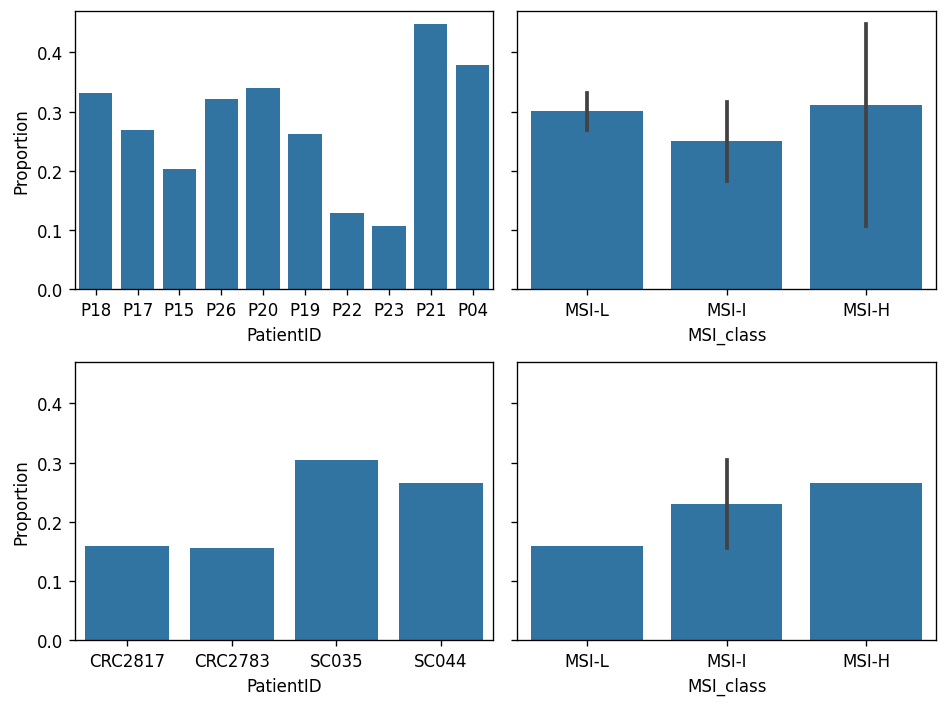

In [243]:


CT_oi = 'CD8+ T'
# CT_oi = 'Monocyte'
fig, axes = plt.subplots(2, 2, figsize=(8, 6), dpi=120, sharey=True)
sns.barplot(data=CellTypeProportion_C[(CellTypeProportion_C['CellType']==CT_oi) & 
                                      (CellTypeProportion_C['BiopsySite']=='Tumor')], x='PatientID', y='Proportion', order=chen_patient_order_by_MSI_intensity, ax=axes[0, 0])
sns.barplot(data=CellTypeProportion_J[(CellTypeProportion_J['CellType']==CT_oi) & 
                                      (CellTypeProportion_J['BiopsySite']=='Tumor')], x='PatientID', y='Proportion', order=joanito_patient_order_by_MSI_intensity, ax=axes[1, 0])

sns.barplot(data=CellTypeProportion_C[(CellTypeProportion_C['CellType']==CT_oi) & 
                                      (CellTypeProportion_C['BiopsySite']=='Tumor')], x='MSI_class', y='Proportion', order=['MSI-L', 'MSI-I', 'MSI-H'], ax=axes[0, 1])
sns.barplot(data=CellTypeProportion_J[(CellTypeProportion_J['CellType']==CT_oi) & 
                                      (CellTypeProportion_J['BiopsySite']=='Tumor')], x='MSI_class', y='Proportion', order=['MSI-L', 'MSI-I', 'MSI-H'], ax=axes[1, 1])
fig.tight_layout();

,PatientID,MSI,BiopsySite,CellType,Count,Proportion
1,CRC2783,MSI-H,Normal,CD8+ T,378,0.100612
25,CRC2783,MSI-H,Tumor,CD8+ T,1433,0.156305
44,CRC2817,MSI-H,Normal,CD8+ T,409,0.105548
69,CRC2817,MSI-H,Tumor,CD8+ T,1635,0.159093
92,SC035,MSI-H,Normal,CD8+ T,36,0.029581
113,SC035,MSI-H,Tumor,CD8+ T,741,0.304062
132,SC044,MSI-H,Normal,CD8+ T,197,0.057334
154,SC044,MSI-H,Tumor,CD8+ T,587,0.265851


In [133]:
adata_C = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/Chen.MSI.preprocessed.NanoMnT.ManualAnnot.MSI_score_labeled.lvl3.h5ad')
adata_J = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/Joanito.MSI.preprocessed.NanoMnT.ManualAnnot.MSI_score_labeled.lvl3.h5ad')

In [191]:
sc.tl.score_genes(adata_C, gene_list=['PRF1', 'GZMB', 'GZMA', 'GZMH', 'NKG7'], score_name='CD8+ Cytotoxic')
sc.tl.score_genes(adata_J, gene_list=['PRF1', 'GZMB', 'GZMA', 'GZMH', 'NKG7'], score_name='CD8+ Cytotoxic')

In [238]:
# sc.tl.score_genes(adata_C, gene_list=['TNF', 'IL1B', 'IL6', 'CXCL8', 'NOS2', 'C3', 'NFKB1', 'STAT1'], 
#                   score_name='Antimicrobial activity')
# sc.tl.score_genes(adata_J, gene_list=['TNF', 'IL1B', 'IL6', 'CXCL8', 'NOS2', 'C3', 'NFKB1', 'STAT1'], 
#                   score_name='Antimicrobial activity')
sc.tl.score_genes(adata_C, gene_list=['S100A6', 'S100A10', ], 
                  score_name='Antimicrobial activity')
sc.tl.score_genes(adata_J, gene_list=['S100A6', 'S100A10', ], 
                  score_name='Antimicrobial activity')  

In [ ]:
for PID in set(adata_J.obs['PatientID']):
    try: dict_PatientID_to_MSI_class[PID]
    except KeyError: dict_PatientID_to_MSI_class[PID] = 'MSS'

adata_C.obs['MSI_class'] = [ dict_PatientID_to_MSI_class[PID] for PID in adata_C.obs['PatientID'] ]
adata_J.obs['MSI_class'] = [ dict_PatientID_to_MSI_class[PID] for PID in adata_J.obs['PatientID'] ]

In [228]:
set(adata_C.obs['Manual_CellType_lvl_3'])

{'CD4+ T',
 'CD8+ T',
 'Endothelial',
 'Enterocytes',
 'Fibroblast',
 'GC B',
 'Glial',
 'Goblet',
 'IGHA+ Plasma',
 'IGHG+ Plasma',
 'Intestinal stem',
 'Macrophage',
 'Mast',
 'Memory B',
 'Monocyte',
 'N/A',
 'NK',
 'Naive B',
 'Pericyte',
 'SMC',
 'SOX6+ Fibroblast',
 'Tumor cell',
 'cDC',
 'gd T',
 'pDC'}

<Axes: xlabel='MSI_class', ylabel='Antimicrobial activity'>

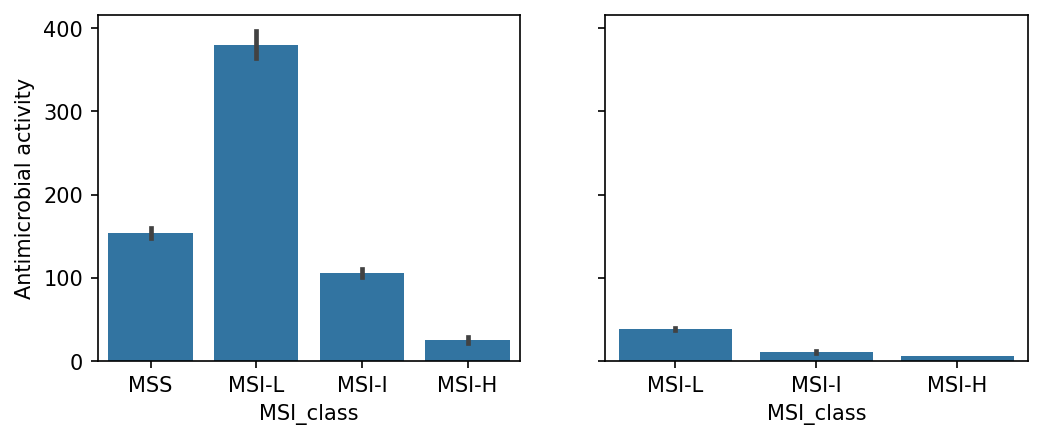

In [239]:
CT_oi = 'Tumor cell'
# CT_oi = 'IGHG+ Plasma'

# sc.pl.violin(adata_J[adata_J.obs['Manual_CellType_lvl_3']=='CD8+ T'], keys=['CD8+ Cytotoxic'], groupby='MSI_class', order=['MSS' ,'MSI-L', 'MSI-I', 'MSI-H'])
# sc.pl.violin(adata_C[adata_C.obs['Manual_CellType_lvl_3']=='CD8+ T'], keys=['CD8+ Cytotoxic'], groupby='MSI_class', order=['MSI-L', 'MSI-I', 'MSI-H'])
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=150, sharey=True, )

sns.barplot(adata_J.obs[(adata_J.obs['Manual_CellType_lvl_3']==CT_oi) & 
                        (adata_J.obs['BiopsySite'].isin(['Tumor', 'Core', 'Invasive']))], 
            y='Antimicrobial activity', x='MSI_class', order=['MSS' ,'MSI-L', 'MSI-I', 'MSI-H'], ax=axes[0])
sns.barplot(adata_C.obs[(adata_C.obs['Manual_CellType_lvl_3']==CT_oi) & 
                        (adata_C.obs['BiopsySite']=='Tumor')], 
            y='Antimicrobial activity', x='MSI_class', order=['MSI-L', 'MSI-I', 'MSI-H'], ax=axes[1])

# sns.boxplot(adata_J.obs[adata_J.obs['Manual_CellType_lvl_3']=='CD8+ T'], y='CD8+ Cytotoxic', x='PatientID', 
#             order=joanito_patient_order_by_MSI_intensity, ax=axes[0], hue='MSI_class')
# sns.boxplot(adata_C.obs[adata_C.obs['Manual_CellType_lvl_3']=='CD8+ T'], y='CD8+ Cytotoxic', x='PatientID', 
#             order=chen_patient_order_by_MSI_intensity, ax=axes[1], hue='MSI_class', legend=None,)